# Reduced Gravity

## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import Common, IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

Plot utils

In [4]:
from IPython.display import clear_output
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
from mpl_toolkits.axes_grid1 import make_axes_locatable

from gpuocean.utils import PlotHelper
from gpuocean.utils.NetCDFInitialization import depth_integration

def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-25, h_max=0, 
                 uv_min=-0.3, uv_max=0.3,
                 calc_uv = False, 
                 add_extra=False,
                 reduced_gravity_interface=None,
                 ax=None, sp=None):


    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000
   
    huv_label = ["hu","hv"]
    if calc_uv:
        """plotting actually u and v"""
        if reduced_gravity_interface is None or reduced_gravity_interface == 0.0:
            hu = hu/(h+eta)
            hv = hv/(h+eta)
        else:
            hu = hu/(reduced_gravity_interface+eta)
            hv = hv/(reduced_gravity_interface+eta)
        # uv_min = -0.3
        # uv_max = +0.3
        huv_label = ["u","v"]

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots

        uv_cmap = plt.cm.coolwarm
        uv_cmap.set_bad("grey", alpha = 1.0)
        
        h_cmap = plt.cm.Blues_r
        if h_max * h_min < 0:
            h_cmap = plt.cm.coolwarm
            h = -eta
        h_cmap.set_bad("grey", alpha = 1.0)

        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(-h, interpolation="none", origin='lower', 
                             cmap=h_cmap, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$\zeta{}$")
        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[0],cax=cax0)


        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=uv_cmap, 
                            vmin=uv_min, vmax=uv_max, 
                            extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[0]+"$")
        divider1 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[1],cax=cax1)



        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=uv_cmap, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[1]+"$")
        divider2 = make_axes_locatable(ax[2])
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[2],cax=cax2)

        plt.tight_layout()
            
    else:        
        #Update plots
        fig.sca(ax[0])
        if h_min*h_max<0:
            sp[0].set_data(eta)
        else:
            sp[0].set_data(-h)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

def ncAnimation(filename, diff_mode=False, movie_frames=None, create_movie=True, fig=None, x0=0, x1=-1, y0=0, y1=-1, reduced_gravity_interface=None, xlow=0, xup=None, ylow=0, yup=None, **kwargs):
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(20, 6))

    try:
        ncfile = Dataset(filename)
        try:
            x = ncfile.variables['x'][:]
        except:
            x = ncfile.variables['X'][x0:x1]
        try:
            y = ncfile.variables['y'][:]
        except:
            y = ncfile.variables['Y'][y0:y1]
        t = ncfile.variables['time'][:]

        try:
            H_m = ncfile.variables['Hm'][:,:]
        except:
            H_m = ncfile.variables['h'][y0:y1,x0:x1]
        try:
            eta = ncfile.variables['eta'][:,:,:]
        except:
            eta = ncfile.variables['zeta'][:,y0:y1,x0:x1]
        minmax = {}
        if diff_mode:
            eta = eta - eta[0]
            minmax["h_min"] = -10
            minmax["h_max"] = 10
        try:
            hu = ncfile.variables['hu'][:,:,:]
            calc_uv = True
        except:
            if reduced_gravity_interface is None:
                hu = ncfile.variables['ubar'][:,y0:y1,x0:x1]
                calc_uv = False
            else:
                if reduced_gravity_interface > 0.0:
                    hu = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hu[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "u", timestep_index=t_idx)
                    calc_uv = True
                else:
                    hu = ncfile.variables['u'][:,0,y0:y1,x0:x1]
                    calc_uv = False
        if diff_mode:
            hu = hu - hu[0]
            minmax["uv_min"] = -0.75
            minmax["uv_max"] = 0.75
        try:
            hv = ncfile.variables['hv'][:,:,:]
        except:
            if reduced_gravity_interface is None:
                hv = ncfile.variables['vbar'][:,y0:y1,x0:x1]
            else:
                if reduced_gravity_interface > 0.0:
                    hv = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hv[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "v", timestep_index=t_idx)
                else:
                    hv = ncfile.variables['v'][:,0,y0:y1,x0:x1]
        if diff_mode:
            hv = hv - hv[0]
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              (eta[0])[ylow:yup, xlow:xup],
                              (hu[0])[ylow:yup, xlow:xup],
                              (hv[0])[ylow:yup, xlow:xup],
                              (H_m+eta[0])[ylow:yup, xlow:xup],
                              dx, dy, 
                              t[0], "Initalised from Mixed Layer Daily-Average",
                              **minmax,
                              calc_uv=calc_uv,
                              reduced_gravity_interface=reduced_gravity_interface,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1][ylow:yup, xlow:xup],
                              hu[-1][ylow:yup, xlow:xup],
                              hv[-1][ylow:yup, xlow:xup],
                              (H_m+eta[-1])[ylow:yup, xlow:xup],
                              dx, dy, 
                              t[-1], filename,
                              **minmax,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                        ((1-s)*eta[j] + s*eta[k])[ylow:yup, xlow:xup], 
                        ((1-s)*hu[j]  + s*hu[k])[ylow:yup, xlow:xup], 
                        ((1-s)*hv[j]  + s*hv[k])[ylow:yup, xlow:xup], 
                        (H_m+(1-s)*eta[j] + s*eta[k])[ylow:yup, xlow:xup], 
                        dx, dy, 
                        t_now, "Initalised from Mixed Layer Daily-Average",
                        **minmax,
                        calc_uv=calc_uv,
                        reduced_gravity_interface=reduced_gravity_interface,
                        **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        #print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=250)
    plt.close(fig)
    
    return anim


## Selecting Area

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
casename = 'skagerrak'

from importlib import reload
from gpuocean.utils import NetCDFInitialization
reload(NetCDFInitialization)
case_info = NetCDFInitialization.getCaseLocation(casename)
case_info.pop("name")

'skagerrak'

In [6]:
locals().update(case_info)

## Construct initial conditions

In [7]:
#s_source_url = "C:\\Users\\florianb\\Downloads\\ocean_his.an.20190716.nc"
s_source_url = "/sintef/data/NorKyst800/ocean_avg.an.20190716.nc"

In [8]:
from importlib import reload 
reload(NetCDFInitialization)
data_args = NetCDFInitialization.getInitialConditions(s_source_url, x0, x1, y0, y1, download_data=False, norkyst_data=False)
NetCDFInitialization.removeMetadata(data_args).keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind_stress'])

In [9]:
data_args.pop("wind_stress")
# from gpuocean.utils import WindStress
# data_args["wind_stress"] = WindStress.WindStress(X=[np.array([[100]])],Y=[np.array([[0]])])

In [10]:
data_args["f"] = 1.2e-4
data_args["latitude"] = None

In [11]:
mld = NetCDFInitialization.fill_coastal_data(NetCDFInitialization.MLD(s_source_url, 1025, min_mld=5, max_mld=40, x0=x0-2, x1=x1+2, y0=y0-2, y1=y1+2))

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


In [12]:
import copy 
mld_orig = copy.deepcopy(mld) 

In [13]:
s_nc = Dataset(s_source_url)
s_hs = s_nc["h"][y0-2:y1+2,x0-2:x1+2]

bad_yx = np.where(np.logical_or(np.abs(mld - s_hs) < 0.35*s_hs, np.abs(mld - s_hs) < 3))
bad_mask = np.where(np.logical_and((s_hs!=5.0), np.logical_and(np.abs(mld - s_hs) > 0.35*s_hs, np.abs(mld - s_hs) > 3)),0,1)

Xidx = np.arange(0, 504)
Yidx = np.arange(0, 254)

xx, yy = np.meshgrid(Xidx, Yidx)

K = 20

for i in range(len(bad_yx[0])):
    dists = (xx-bad_yx[1][i])**2 + (yy-bad_yx[0][i])**2 + 1e5*bad_mask
    sum = 0.0
    for k in range(K): 
        sum += mld[np.unravel_index(dists.argmin(), dists.shape)]
        dists[np.unravel_index(dists.argmin(), dists.shape)] = 1e5
    mld[bad_yx[0][i],bad_yx[1][i]] = sum/K

In [14]:
mld = NetCDFInitialization.fill_coastal_data(mld)

In [15]:
integrator = NetCDFInitialization.MLD_integrator(s_source_url, mld, x0=x0-2, x1=x1+2, y0=y0-2, y1=y1+2)

Calculate reduced gravity based on formula from Røed 

In [16]:
s_pot_densities = NetCDFInitialization.potentialDensities(s_source_url, t=0, x0=x0-1, x1=x1+1, y0=y0-1, y1=y1+1)

ml_pot_density = np.average(np.sum(integrator[:,1:-1,1:-1] * s_pot_densities, axis=0)/np.sum(integrator[:,1:-1,1:-1], axis=0))

inverse_integrator = np.ma.array(np.ones_like(integrator), mask=integrator.mask.copy()) - integrator
deep_pot_density  = np.average(np.sum(inverse_integrator[:,1:-1,1:-1] * s_pot_densities, axis=0)/np.sum(inverse_integrator[:,1:-1,1:-1], axis=0))

eps = (deep_pot_density - ml_pot_density)/deep_pot_density

data_args["g"] = eps*data_args["g"] 

In [17]:
data_args["g"]

0.013348175867676556

No bathymetry friction

In [18]:
data_args["r"] = 0.0

Constant reference bathymetry

In [19]:
H = 5.0
data_args["H"] = np.ma.array(H*np.ones_like(data_args["H"]), mask=data_args["H"].mask.copy(), dtype=np.float32)

MLD as bathymetry

In [20]:
data_args["eta0"] = np.ma.array(mld.data[2:-2,2:-2] - H, mask=mld[2:-2,2:-2].mask, dtype=np.float32)

Geostrophic balance

In [21]:
#Calculate derivatives
DetaDx, DetaDy = np.gradient(mld[1:-1,1:-1])
DetaDx = DetaDx / data_args["dx"]
DetaDy = DetaDy / data_args["dy"]

#Get north and east vectors
angle = NetCDFInitialization.getInitialConditions(s_source_url, x0-1, x1+1, y0-1, y1+1, download_data=False, norkyst_data=False)["angle"] #one halo needed
north = [np.sin(angle), np.cos(angle)]
east = [np.cos(angle), -np.sin(angle)]

#Calculat derivatives towards north and east for eta
DetaDeast = east[0]*DetaDx + east[1]*DetaDy
DetaDnorth = north[0]*DetaDx + north[1]*DetaDy

#Calculate h
h = mld[1:-1,1:-1]

#Get northward and eastward momentums
hu_east = -data_args["g"]/data_args["f"] * h * DetaDnorth
hv_north = data_args["g"]/data_args["f"] * h * DetaDeast

# Analytic inversion of 2x2 linear system
det = east[0]*north[1] - east[1]*north[0]

hu0 = 1/det * ( north[1] * hu_east - east[1] * hv_north )
hv0 = 1/det * ( -north[0] * hu_east + east[0] * hv_north)

In [22]:
hu0 = np.ma.maximum(hu0, -10)
hu0 = np.ma.minimum(hu0, +10)

hv0 = np.ma.maximum(hv0, -10)
hv0 = np.ma.minimum(hv0, +10)

In [23]:
hu0.data[hu0.mask == True] = 0.0
hv0.data[hv0.mask == True] = 0.0

Initial momenta from geostroiphic balance

In [24]:
data_args["hu0"] = np.ma.array(hu0.data[1:-1,1:-1], mask = hu0.mask[1:-1,1:-1])
data_args["hv0"] = np.ma.array(hv0.data[1:-1,1:-1], mask = hv0.mask[1:-1,1:-1])

Check the geostrophic balance!!!

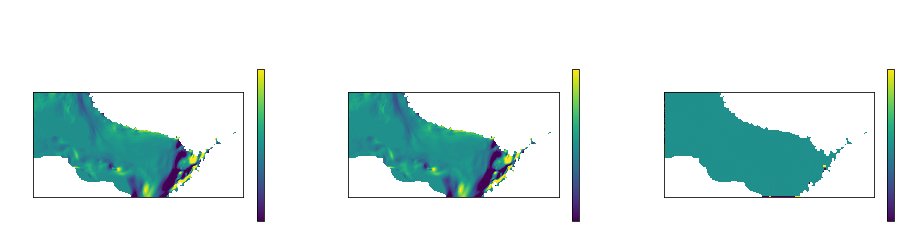

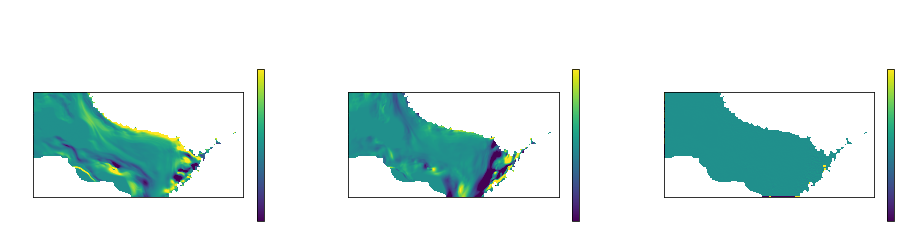

In [25]:
from gpuocean.utils import OceanographicUtilities
geos, geos_x, geos_y = OceanographicUtilities.calcGeostrophicBalance(data_args["eta0"], H, data_args["hu0"], data_args["hv0"], data_args["angle"], data_args["f"], data_args["dx"], data_args["dy"], g=data_args["g"])

plt.figure(figsize=(16,4))
plt.suptitle("Geostrophic balance (hu)")
plt.subplot(1,3,1)
plt.title("Coriolis contribution")
plt.imshow(geos_x[0], origin='lower', vmax=0.0002, vmin=-0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,2)
plt.title("Momentum contribution")
plt.imshow(geos_x[1], origin='lower', vmax=0.0002, vmin=-0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Geostrophic imbalance")
plt.imshow(geos[0], origin='lower', vmax=2e-9, vmin=-2e-9)
plt.colorbar(shrink=0.7)

plt.figure(figsize=(16,4))
plt.suptitle("Geostrophic balance (hv)")
plt.subplot(1,3,1)
plt.title("Coriolis contribution")
plt.imshow(geos_y[0], origin='lower', vmax=0.0002, vmin=-0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,2)
plt.title("Momentum contribution")
plt.imshow(geos_x[1], origin='lower', vmax=0.0002, vmin=-0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Geostrophic imbalance")
plt.imshow(geos[1], origin='lower', vmax=2e-9, vmin=-2e-9)
plt.colorbar(shrink=0.7)

Corresponding (constant) boundary conditions

In [26]:
data_args["boundary_conditions_data"].north.h = np.array([mld[-2,2:-2]-H], dtype=np.float32)
data_args["boundary_conditions_data"].south.h = np.array([mld[1,2:-2]-H], dtype=np.float32)
data_args["boundary_conditions_data"].east.h = np.array([mld[2:-2,-2]-H], dtype=np.float32)
data_args["boundary_conditions_data"].west.h = np.array([mld[2:-2,1]-H], dtype=np.float32)

data_args["boundary_conditions_data"].north.hu = np.array([hu0[-1,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].south.hu = np.array([hu0[0,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].east.hu = np.array([hu0[1:-1,-1]], dtype=np.float32)
data_args["boundary_conditions_data"].west.hu = np.array([hu0[1:-1,0]], dtype=np.float32)

data_args["boundary_conditions_data"].north.hv = np.array([hv0[-1,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].south.hv = np.array([hv0[0,1:-1]], dtype=np.float32)
data_args["boundary_conditions_data"].east.hv = np.array([hv0[1:-1,-1]], dtype=np.float32)
data_args["boundary_conditions_data"].west.hv = np.array([hv0[1:-1,0]], dtype=np.float32)

## Simulation

In [37]:
sim_args = {
    "gpu_ctx": gpu_ctx,
    "dt": 0.0,
    "write_netcdf":True,
    "rk_order":1
     }
    
from importlib import reload
reload(CDKLM16)

sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args))
#sim = CDKLM16.CDKLM16(**sim_args, **NetCDFInitialization.removeMetadata(data_args), static_eta=True)

This will give inaccurate angle along the border!


Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/netcdf_2022_09_01/CDKLM16_2022_09_01-15_26_16.nc ...


CHECK CHECK CHECK

In [35]:
sim.step(60)

60.0

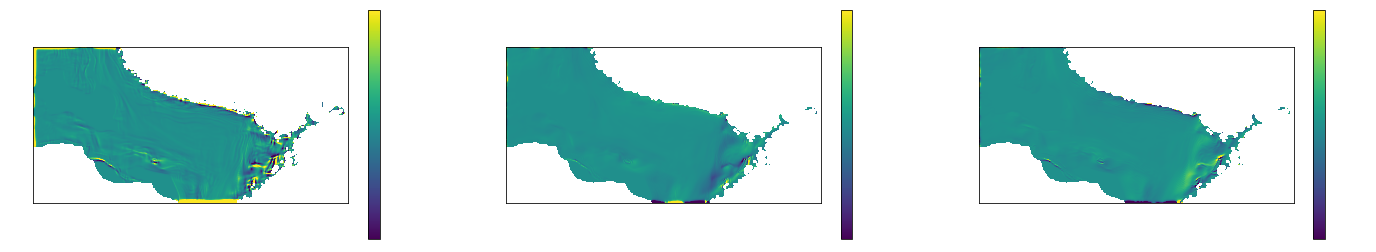

In [36]:
eta, hu, hv = sim.download(interior_domain_only=True)

fig, axs = plt.subplots(1,3, figsize=(24,12))

im = axs[0].imshow(eta, origin="lower", vmin=-0.1, vmax=0.1)
plt.colorbar(im, ax=axs[0], shrink=0.35)

im = axs[1].imshow(hu, origin="lower", vmin=-0.1, vmax=0.1)
plt.colorbar(im, ax=axs[1], shrink=0.35)

im = axs[2].imshow(hv, origin="lower", vmin=-0.1, vmax=0.1)
plt.colorbar(im, ax=axs[2], shrink=0.35)

In [30]:
STOP!!!

Exception caught: Resetting to CUDA context gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3225, in run_cell_async
    code_ast = compiler.ast_parse(cell, filename=cell_name)
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/compilerop.py", line 101, in ast_parse
    return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)
  File "/tmp/ipykernel_226410/3246949926.py", line 1
    STOP!!!
        ^
SyntaxError: invalid syntax


SyntaxError: invalid syntax (3246949926.py, line 1)

Animation

In [38]:
for hour in range(24):
    sim.step(3600.0, apply_stochastic_term=False)

In [39]:
anim = ncAnimation(sim.sim_writer.output_file_name)
anim

In [40]:
sim.g

0.013348176